In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import pandas as pd
from scipy import stats
import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

L=60
input_shape = (L, 1)
n_class = 3

In [2]:
def Show_history(fit, label =''):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.set_title(label+'')
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.set_title(label+' Loss ')
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()


In [3]:
def show_confusion_matrix(validations, predictions, label="Model"):
    LABELS = ["absent","positive","negative"]
    cmap="GnBu"
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Study the performance of the CNN by varying the amplitude A of the patterns while keeping DX fixed, namely by changing the signal-to-noise ratio.

In [15]:
import numpy as np
jump = lambda drift, stdev: int(np.random.normal(drift,stdev))

def pattern(i,z,a):
    p = a*np.sin((np.pi*i)/z)
    return p.astype(int) #Use numpy convesion instead it aviods "IOPub data rate exceeded"

def gen_data(A=500): #Generate datasets with varying A     
    np.random.seed(12345)
    Z=12 # Z=nr of steps
    N=10000  # number of data samples
    L=60 # size of each sample of the timeseries 
    DX = 50  # step parameters: introduce small positive bias 
    bias = 5

    y = [0] * N
    x = [[0] * L for i in range(N)] 
    for i in range(N):
        if i>0:
            x[i][0] = x[i-1][-1] + jump(bias,DX)
        for j in range(1,L):
            x[i][j] = x[i][j-1] + jump(bias,DX)  
        y[i] = i%3 
        if y[i]>0:
            j0 = np.random.randint(0,L-1-Z)
            sign = 3-2*y[i]
            for j in range(Z):
                x[i][j0+j] += sign*pattern(j,Z,A)
    return np.asarray(x), np.asarray(y)

def prep_data(x,y):
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]

    x = x/400
    
    #spliting of training and validation 
    perc_train=0.8 
    N_train = int(perc_train*N)
    x_train = x[:N_train]
    y_train = y[:N_train]
    x_val = x[N_train:]
    y_val = y[N_train:]

    # Keras wants an additional dimension with a 1 at the end
    x_train = x_train.reshape(x_train.shape[0], L, 1)
    x_val =  x_val.reshape(x_val.shape[0], L, 1)
    input_shape = (L, 1)
    return x_train, y_train, x_val, y_val, input_shape

def build_model(NCONV=1):
    reg = tf.keras.regularizers.l2(0.2) ## raised to 0.2
    #reg = regularizers.l1(0.1)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                            seed=None)
    NCONV = 1
    NF = 5
    # challenge: at most 600 tunable parameters
    model = Sequential()
    if NCONV==1:
        # -----2-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                         kernel_initializer=ini, 
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, 
                         activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
    if NCONV==2:
        # -----1-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                         kernel_initializer=ini, 
                         kernel_regularizer=reg, ######## TRY WITHOUT !
                         activation='relu', input_shape=input_shape))

        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(9, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(6, activation='relu'))
        model.add(Dropout(0.2))

    model.add(Dense(n_class, activation='softmax'))
    opt = tf.keras.optimizers.Adam()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,metrics=['accuracy'])
    return model

def build_model2(model):
    opt = tf.keras.optimizers.Adam()
    reg2 = tf.keras.regularizers.l1(0.5)
    model2 = keras.models.clone_model(model) #based on model1
    model2.layers[0].kernel_regularizer = reg2
    model2.layers[2].kernel_regularizer = reg2
    model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

    return model2

Amplitudes  =[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,800]
model = build_model()
model2 = build_model2(model)
BATCH_SIZE = 250
EPOCHS = 100
accuracy_1 =[]
accuracy_2 =[]

for A in Amplitudes:
    print('A = ', A)
    x, categ = gen_data(A)
    n_class = 3
    N,L = len(x), len(x[0])
    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1. #prof does it here but might add to gen_data 
    x_train, y_train, x_val, y_val, input_shape = prep_data(x,y)
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True) 

    fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
                validation_data=(x_val, y_val), verbose=0, shuffle=True) 
    
    
    accuracy_1.append(fit.history['accuracy'][-1])
    accuracy_2.append(fit2.history['accuracy'][-1])
    #Show_history(fit, "Model 1, A = "+str(A))
    #Show_history(fit2, "Model 2, A = "+str(A))
    y_pred_val = model.predict(x_val)
    y_pred_val2 = model2.predict(x_val)
    # Take the class with the highest probability from the val predictions
    max_y_pred_val = np.argmax(y_pred_val, axis=1)
    max_y_val = np.argmax(y_val, axis=1)
    max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

    #show_confusion_matrix(max_y_val, max_y_pred_val, label="Model 1, A = "+str(A))
    #show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2, A = "+str(A))
    
print(accuracy_1)
print(accuracy_2)

A =  0
A =  50
A =  100
A =  150
A =  200
A =  250
A =  300
A =  350
A =  400
A =  450
A =  500
A =  550
A =  600
A =  650
A =  700
A =  800
[0.3292500078678131, 0.3232499957084656, 0.3321250081062317, 0.3318749964237213, 0.33024999499320984, 0.3333750069141388, 0.3232499957084656, 0.33000001311302185, 0.32912498712539673, 0.33125001192092896, 0.3333750069141388, 0.32487499713897705, 0.32087498903274536, 0.32749998569488525, 0.3333750069141388, 0.32875001430511475]
[0.351500004529953, 0.35899999737739563, 0.3813750147819519, 0.41449999809265137, 0.4957500100135803, 0.5898749828338623, 0.6884999871253967, 0.7866250276565552, 0.8628749847412109, 0.906125009059906, 0.9346250295639038, 0.9591249823570251, 0.9727500081062317, 0.9848750233650208, 0.9900000095367432, 0.9918749928474426]


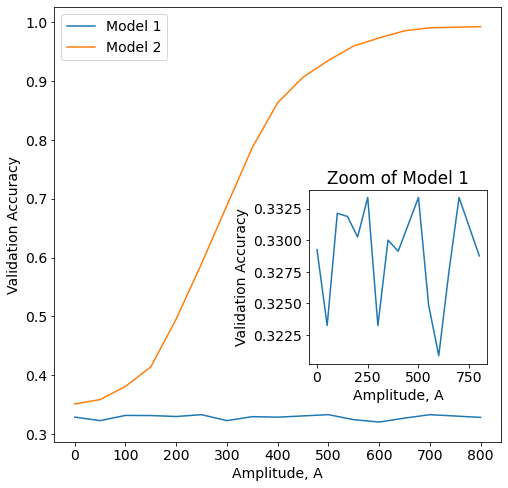

In [28]:
fig, ax =plt.subplots(1,1,figsize=(8,8))

ax.plot(Amplitudes, accuracy_1, label ="Model 1")
ax.plot(Amplitudes, accuracy_2, label ="Model 2")
ins = ax.inset_axes([0.57,0.18,0.4,0.4])
ax.set_xlabel("Amplitude, A")
ax.set_ylabel("Validation Accuracy")
ax.legend()
ins.plot(Amplitudes, accuracy_1)
#ins.plot(Amplitudes, accuracy_2)
ins.set_xlabel("Amplitude, A")
ins.set_ylabel("Validation Accuracy")
ins.set_title("Zoom of Model 1")
plt.show()